We're going to expand our decision tree model into an entire forest (an example of something called an ensemble model); how to use a grid search to tune hyperparameters; and create a function that loads data and a pre-trained model, and uses that model to generate a Series of predictions.

In [ ]:
# import libraries
import gzip
import json
import pickle

import matplotlib.pyplot as plt
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from IPython.display import VimeoVideo
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline


* Import data

In [ ]:
def wrangle(filename):
    #Open compressed file, load into dict
    with gzip.open(filename, "r") as read_file:
        data = json.load(read_file)

    # Turn dict into DataFrame
    df = pd.DataFrame().from_dict(data["data"]).set_index("company_id")
    
    return df

In [ ]:
df = wrangle("data/poland-bankruptcy-data-2009.json.gz")
print(df.shape)
df.head()

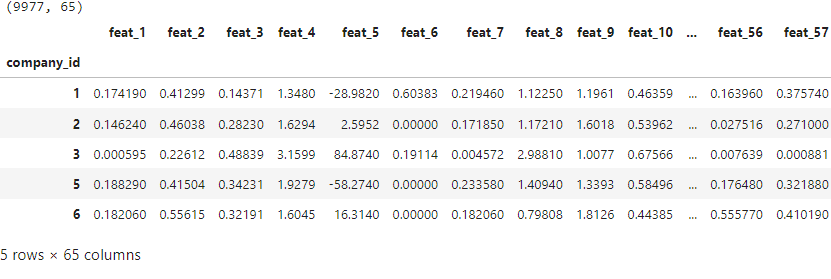

Split

Creating our feature matrix X and target vector y. Our target is "bankrupt".

In [ ]:
target = "bankrupt"
X = df.drop(columns =target)
y = df[target]

print("X shape:", X.shape)
print("y shape:", y.shape)

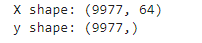

Dividing our data (X and y) into training and test sets using a randomized train-test split. Our test set should be 20% of Our total data. And set a random_state for reproducibility.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size= 0.2, random_state= 42
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

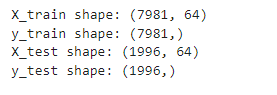

Over sampling

Creating a new feature matrix X_train_over and target vector y_train_over by performing random over-sampling on the training data

In [ ]:
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
print("X_train_over shape:", X_train_over.shape)
X_train_over.head()

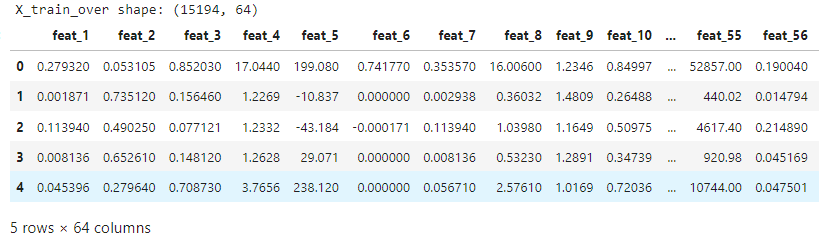

Build Model

Now that we have our data set up the right way, we can build the model. 

Baseline

In [ ]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 4))

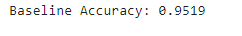

Iterate

If we could somehow use more than one model simultaneously, we'd have a more trustworthy prediction.

Ensemble models work by building multiple models on random subsets of the same data, and then comparing their predictions to make a final prediction. We're going to create an ensemble of trees. This type of model is called a random forest.

We'll start by creating a pipeline to streamline our workflow.


Creating a pipeline named clf (short for "classifier") that contains a SimpleImputer transformer and a RandomForestClassifier predictor.

In [ ]:
clf = make_pipeline(SimpleImputer(), RandomForestClassifier(random_state=42))
print(clf)

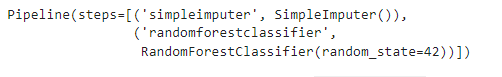

Cross-Validation

By default, the number of trees in our forest (n_estimators) is set to 100. That means when we train this classifier, we'll be fitting 100 trees. While it will take longer to train, it will hopefully lead to better performance.

In order to get the best performance from our model, we need to tune its hyperparameter. But how can we do this if we haven't created a validation set? The answer is cross-validation. So, before we look at hyperparameters, let's see how cross-validation works with the classifier we just built.

In [ ]:
cv_acc_scores = cross_val_score(clf, X_train_over, y_train_over, cv=5, n_jobs=-1)
print(cv_acc_scores)

Parameter Grid

Let's tune our model. The first step is creating a range of hyperparameters that we want to evaluate.
Creating a dictionary with the range of hyperparameters that we want to evaluate for our classifier

In [ ]:
params = {
    "simpleimputer__strategy": ["mean", "median"],
    "randomforestclassifier__n_estimators":range(25,100,25),
    "randomforestclassifier__max_depth":range(10,50,10)
}
params

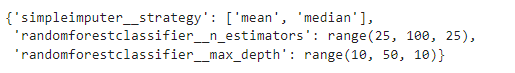

Now that we have our hyperparameter grid, let's incorporate it into a grid search.

Creating a GridSearchCV named model that includes our classifier and hyperparameter grid.

In [ ]:
model = GridSearchCV(
    clf,
    param_grid=params,
    cv=5,
    n_jobs= -1,
    verbose= 1
)
model

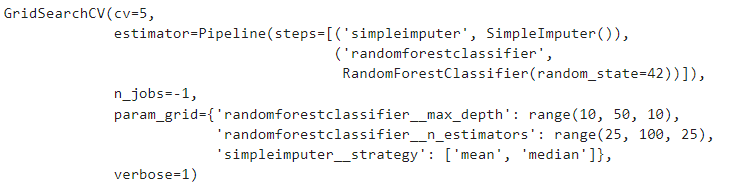

Fit Model

Fitting model to the over-sampled training data.

In [ ]:
# Train model
model.fit(X_train_over, y_train_over)

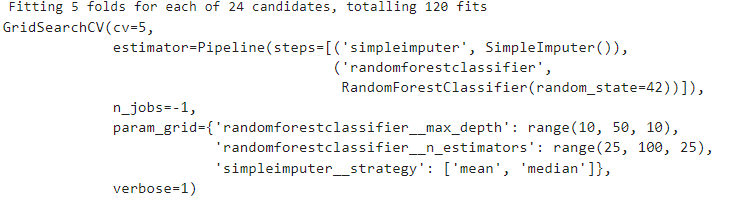

Grid search Cv results

Now that we've tested all those models, let's take a look at the results

In [ ]:
cv_results = pd.DataFrame(model.cv_results_)
cv_results.head(10)

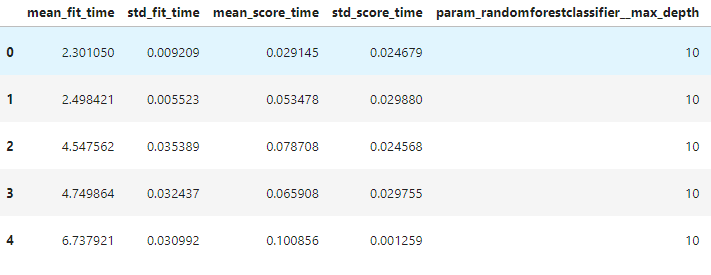

Training Time vs N Estimators

First, we'll look at n_estimators. Our grid search evaluated this hyperparameter for various max_depth settings, but let's only look at models where max_depth equals 10.

Creating a mask for cv_results for rows where "param_randomforestclassifier__max_depth" equals 10. Then plotting "param_randomforestclassifier__n_estimators" on the x-axis and "mean_fit_time" on the y-axis. 

In [ ]:
# Create mask
mask = cv_results["param_randomforestclassifier__max_depth"] == 10
# Plot fit time vs n_estimators
plt.plot(
    cv_results[mask]["param_randomforestclassifier__n_estimators"],
    cv_results[mask]["mean_fit_time"]
)
# Label axes
plt.xlabel("Number of Estimators")
plt.ylabel("Mean Fit Time [seconds]")
plt.title("Training Time vs Estimators (max_depth=10)");

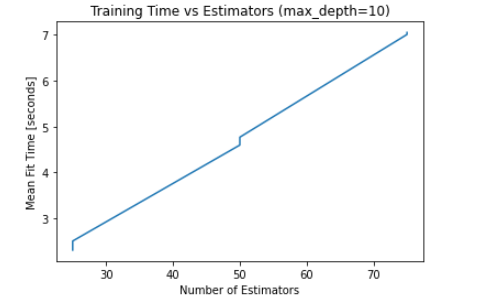

Training Time vs Max Depth

Next, we'll look at max_depth. Here, we'll also limit our data to rows where n_estimators equals 25.

Create a mask for cv_results for rows where "param_randomforestclassifier__n_estimators" equals 25. Then plot "param_randomforestclassifier__max_depth" on the x-axis and "mean_fit_time" on the y-axis. Don't forget to label your axes and include a title

In [ ]:
# Create mask
mask = cv_results["param_randomforestclassifier__n_estimators"] == 25
# Plot fit time vs max_depth
plt.plot(
    cv_results[mask]["param_randomforestclassifier__max_depth"],
    cv_results[mask]["mean_fit_time"]
)
# Label axes
plt.xlabel("Max Depth")
plt.ylabel("Mean Fit Time [seconds]")
plt.title("Training Time vs Max Depth (n_estimators=25)");

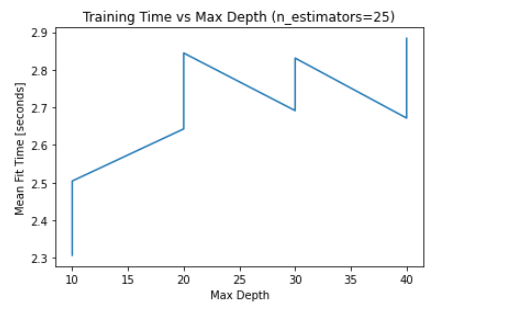

There's a general upwards trend, but we see a lot of up-and-down here. That's because for each max depth, grid search tries two different imputation strategies: mean and median. Median is a lot faster to calculate, so that speeds up training time.

Finally, let's look at the hyperparameters that led to the best performance

In [ ]:
cv_results[mask][["mean_fit_time","param_randomforestclassifier__max_depth", "param_simpleimputer__strategy"]]

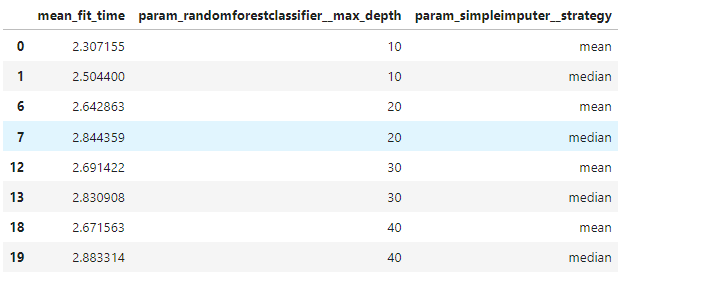

 Extract the best hyperparameters from model

In [ ]:
# Extract best hyperparameters
model.best_params_

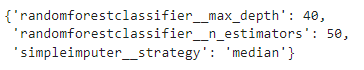

Note that we don't need to build and train a new model with these settings. Now that the grid search is complete, when we use model.predict(), it will serve up predictions using the best model.

In [ ]:
model.best_estimator_

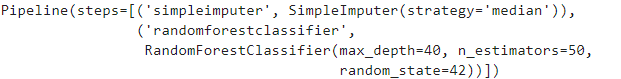

In [ ]:
model.predict(X_train_over)

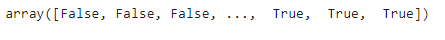

* Evaluate

Let's see how our model performs.

Calculating the training and test accuracy scores for model.

In [ ]:
acc_train = model.score(X_train, y_train)
acc_test = model.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 4))
print("Test Accuracy:", round(acc_test, 4))

We beat the baseline! Just barely, but we beat it.

Next, we're going to use a confusion matrix to see how our model performs. To better understand the values we'll see in the matrix, let's first count how many observations in our test set belong to the positive and negative classes.

In [ ]:
y_test.value_counts()

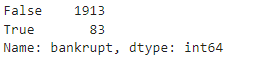

Confusion Matrix

Plotting a confusion matrix that shows how our best model performs on our test set.

In [ ]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test);

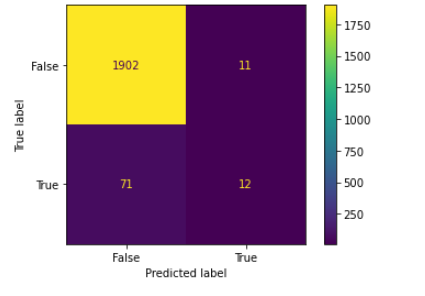

* Communicate

Extract Feature Importance

Creating a horizontal bar chart with the 10 most important features for our model.

In [ ]:
features= X_train_over.columns
features

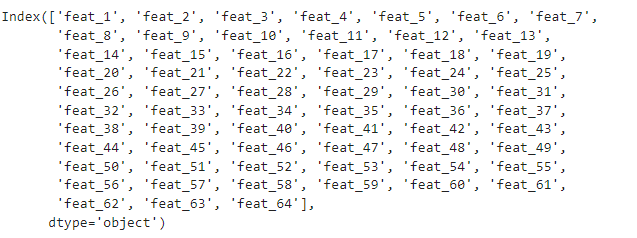

In [ ]:
importances= model.best_estimator_.named_steps[
    "randomforestclassifier"
]. feature_importances_
importances

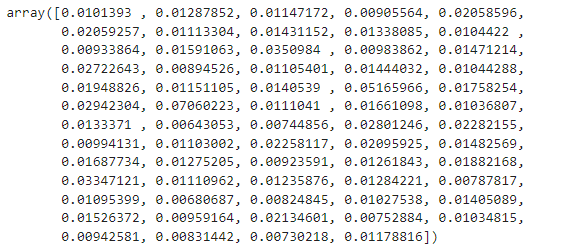

In [ ]:
# Get feature names from training data
features = X_train_over.columns
# Extract importances from model
importances = importances= model.best_estimator_.named_steps[
    "randomforestclassifier"
]. feature_importances_
importances
# Create a series with feature names and importances
feat_imp = pd.Series(importances, index=features).sort_values()
# Plot 10 most important features
feat_imp.tail(10).plot(kind="barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("Feature Importance");

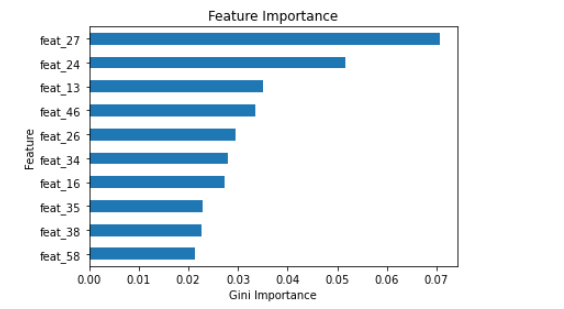

Feature 27 is most important features in bankruptcy

Save model 

Using a context manager, save our best-performing model to a a file named "model-5-3.pkl"

In [ ]:
# Save model
with open("model-5-3.pkl", "wb") as f:
    pickle.dump(model, f)

"Make Predictions" Function

Creating a function make_predictions. It should take two arguments: the path of a JSON file that contains test data and the path of a serialized model. The function should load and clean the data using the wrangle function we created, load the model, generate an array of predictions, and convert that array into a Series. (The Series should have the name "bankrupt" and the same index labels as the test data.) Finally, the function should return its predictions as a Series

In [ ]:
def make_predictions(data_filepath, model_filepath):
    # Wrangle JSON file
    X_test = wrangle(data_filepath)
    # Load model
    with open( model_filepath, "rb") as f:
        model= pickle.load(f)
    # Generate predictions
    y_test_pred = model.predict(X_test)
    # Put predictions into Series with name "bankrupt", and same index as X_test
    y_test_pred = pd.Series(y_test_pred, index= X_test.index, name ="bankrupt")
    return y_test_pred